# REGCOIL
This example reproduces REGCOIL results, and performs a Taylor test
that compares QUADCOIL derivatives with the results yielded by 
finite-differencing many REGCOIL results. 

This notebook requires the regcoil branch of simsopt for running 
REGCOIL and loading data. QUADCOIL itself does not depend on 
Simsopt or REGCOIL.

In [1]:
from quadcoil import quadcoil

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax import block_until_ready
import time

In [3]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [4]:
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', False)

## Solving the REGCOIL problem (automatic winding surface)
QUADCOIL inputs are strings and numpy/jax.numpy arrays. 


It only requires 
`from quadcoil import quadcoil`
unless non-default winding surface generators are required.


In [5]:
# First, test with the REGCOIL problem, auto-generating WS.
print('Running REGCOIL, with auto-generated winding surface')
regcoil1_out_dict, regcoil1_qp, regcoil1_dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B + 0.01 f_K
    objective_name=('f_B', 'f_K'),
    objective_weight=np.array([1., 0.01]),
    # Usually we recommend normalizing f_B and f_K to 
    # ~1, but in this case, for testing prupose, not normalizing 
    # is also okay
    objective_unit=(1., 1.), 
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
)

Running REGCOIL, with auto-generated winding surface


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


QUADCOIL f_B: 0.95697623
REGCOIL f_B:  0.9569913414171621


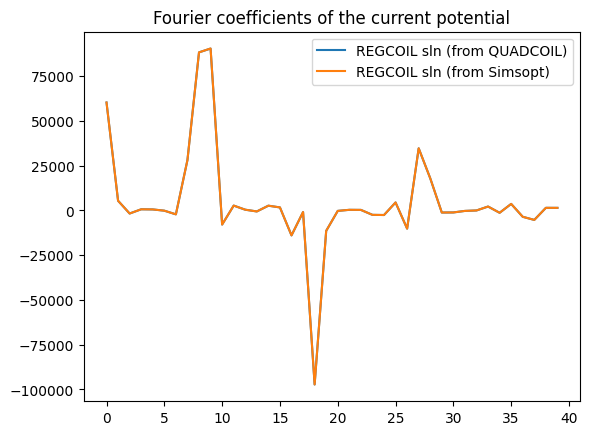

In [6]:
# Extract the winding surface and run REGCOIL
ws1 = regcoil1_qp.winding_surface.to_simsopt()
cp1 = CurrentPotentialFourier(
    ws1, mpol=mpol, ntor=ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    stellsym=True)
cpst1 = CurrentPotentialSolve(cp1, plasma_surface, 0)
regcoil1_phi_mn = regcoil1_dofs['phi']
regcoil1_phi_mn_ans, regcoil1_f_B_ans, regcoil1_f_K_ans = cpst1.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()
print('QUADCOIL f_B:', regcoil1_out_dict['f_B']['value'])
print('REGCOIL f_B: ', regcoil1_f_B_ans)

## Running the REGCOIL problem (given winding surface)

In [7]:
# Then, test with REGCOIL, given winding surface.
print('Testing REGCOIL, with known winding surface')
regcoil2_out_dict, regcoil2_qp, regcoil2_phi_mn, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    winding_dofs=winding_surface.get_dofs(),
    winding_mpol=winding_surface.mpol,
    winding_ntor=winding_surface.ntor,
    winding_quadpoints_phi=winding_surface.quadpoints_phi,
    winding_quadpoints_theta=winding_surface.quadpoints_theta,
    objective_name=('f_B', 'f_K'),
    objective_weight=np.array([1., 0.01]),
    objective_unit=(1., 1.),
    metric_name=('f_B', 'f_K')
)

Testing REGCOIL, with known winding surface


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


QUADCOIL f_B: 1.7842494
REGCOIL f_B:  1.7840353600332435


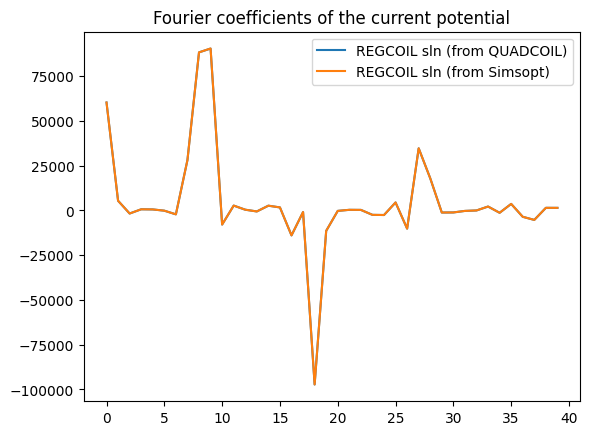

In [8]:
# Comparing with REGCOIL
cp = CurrentPotentialFourier(
    winding_surface, mpol=4, ntor=4,
    net_poloidal_current_amperes=11884578.094260072,
    net_toroidal_current_amperes=0,
    stellsym=True)
cpst = CurrentPotentialSolve(cp, plasma_surface, jnp.zeros(1024))
regcoil2_phi_mn_ans, regcoil2_f_B_ans, regcoil2_f_K_ans = cpst.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()
print('QUADCOIL f_B:', regcoil2_out_dict['f_B']['value'])
print('REGCOIL f_B: ', regcoil2_f_B_ans)

## Taylor test
Test QUADCOIL derivatives against REGCOIL + finite difference

In [9]:
plasma_dof_orig = plasma_surface.get_dofs()
plasma_dof_0_list = []
phi_test_list = []
f_B_test_list = []
f_K_test_list = []
phi_ans_list = []
f_B_ans_list = []
f_K_ans_list = []
f_B_diff_test_list = []
f_K_diff_test_list = []
time_quadcoil_list = []
time_regcoil_list = []
for i in jnp.linspace(-0.1, 0.1, 200):
    plasma_dof_i = plasma_dof_orig.copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    regcoili_out_dict, regcoili_qp, regcoili_dofs, status = quadcoil(
        nfp=plasma_surface.nfp,
        stellsym=plasma_surface.stellsym,
        mpol=mpol,
        ntor=ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=cpst.plasma_surface.mpol,
        plasma_ntor=cpst.plasma_surface.ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        plasma_coil_distance=plasma_surface.minor_radius(),
        objective_name=('f_B', 'f_K'),
        objective_weight=np.array([1., 0.01]),
        objective_unit=(1., 1.),
        metric_name=('f_B', 'f_K'),
    )
    block_until_ready(regcoili_dofs)
    block_until_ready(regcoili_out_dict)
    block_until_ready(regcoili_qp)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    # REGCOIL ---------------------------------------------------
    time1 = time.time()
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(regcoili_dofs)
    f_B_test_list.append(regcoili_out_dict['f_B']['value'])
    f_K_test_list.append(regcoili_out_dict['f_K']['value'])
    f_B_diff_test_list.append(regcoili_out_dict['f_B']['grad']['df_dplasma_dofs'][0])
    f_K_diff_test_list.append(regcoili_out_dict['f_K']['grad']['df_dplasma_dofs'][0])
    wsi = regcoili_qp.winding_surface.to_simsopt()
    psi = regcoili_qp.plasma_surface.to_simsopt()
    cpi = CurrentPotentialFourier(
        wsi, mpol=mpol, ntor=ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        stellsym=True)
    cpsti = CurrentPotentialSolve(cpi, psi, 0)
    regcoili_dofs_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(0.01)
    time2 = time.time()
    time_regcoil_list.append(time2-time1)
    phi_ans_list.append(regcoili_dofs_ans)
    f_B_ans_list.append(regcoili_f_B_ans)
    f_K_ans_list.append(regcoili_f_K_ans)
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
print('REGCOIL  avg time:', np.average(time_regcoil_list), '(s)')
print('REGCOIL  max time:', np.max(time_regcoil_list), '(s)')

QUADCOIL avg time: 0.6670623874664307 (s)
QUADCOIL max time: 0.8322818279266357 (s)
REGCOIL  avg time: 0.3157981288433075 (s)
REGCOIL  max time: 0.4593634605407715 (s)


In [10]:
plasma_dof_0_list = jnp.array(plasma_dof_0_list)
# phi_test_list = jnp.array(phi_test_list)
f_B_test_list = jnp.array(f_B_test_list)
f_K_test_list = jnp.array(f_K_test_list)
# phi_ans_list = jnp.array(phi_ans_list)
f_B_ans_list = jnp.array(f_B_ans_list)
f_K_ans_list = jnp.array(f_K_ans_list)
f_B_diff_test_list = jnp.array(f_B_diff_test_list)
f_K_diff_test_list = jnp.array(f_K_diff_test_list)
time_quadcoil_list = jnp.array(time_quadcoil_list)
time_regcoil_list = jnp.array(time_regcoil_list)

Max error: 12582912.0
Avg error: 8472494.0


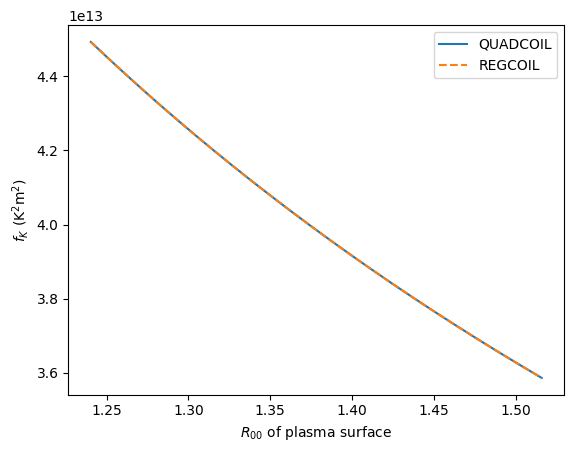

In [11]:
plt.plot(plasma_dof_0_list, f_K_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_K_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_K$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(f_K_test_list - f_K_ans_list)))
print('Avg error:', jnp.average(jnp.abs(f_K_test_list - f_K_ans_list)))

Max error: 0.0005117655
Avg error: 7.582605e-05


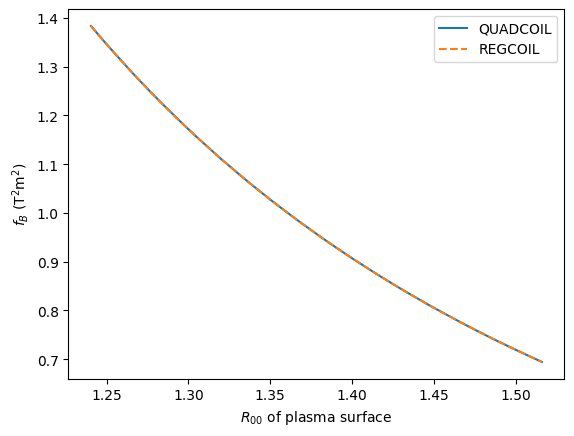

In [12]:
plt.plot(plasma_dof_0_list, f_B_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_B_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_B$ (T$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(f_B_test_list - f_B_ans_list)))
print('Avg error:', jnp.average(jnp.abs(f_B_test_list - f_B_ans_list)))

Max error: 67641540000.0
Avg error: 19631208000.0


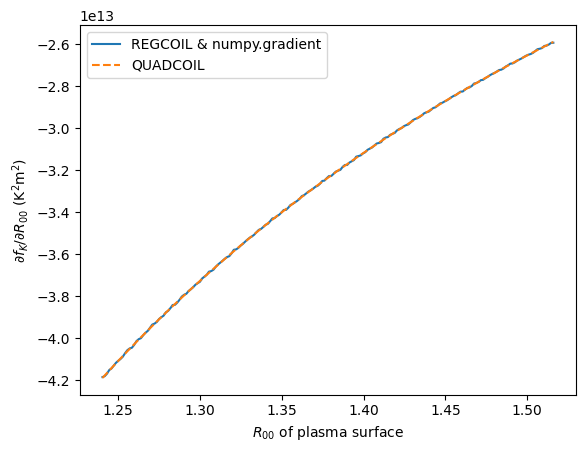

In [13]:
grad_f_K = jnp.gradient(f_K_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_K, label='REGCOIL & numpy.gradient')
plt.plot(plasma_dof_0_list, f_K_diff_test_list, label='QUADCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_K/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_K - f_K_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_K - f_K_diff_test_list)))

Max error: 0.1823082
Avg error: 0.028402172


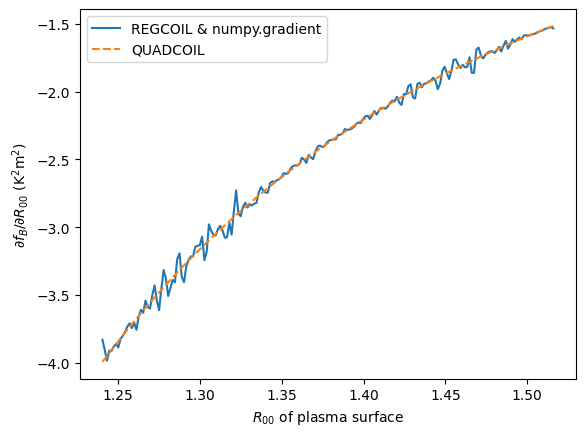

In [14]:
grad_f_B = jnp.gradient(f_B_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_B, label='REGCOIL & numpy.gradient')
plt.plot(plasma_dof_0_list, f_B_diff_test_list, label='QUADCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_B/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_B - f_B_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_B - f_B_diff_test_list)))